### Modified by Brian Rose

to use [intake-esm](https://intake-esm.readthedocs.io/en/latest/) for the data ingestion step

In [2]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xskillscore as xs
import xesmf as xe
import gcsfs
from tqdm.autonotebook import tqdm

from xhistogram.xarray import histogram

import intake
# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

In [3]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

# from dask.distributed import Client
# from dask_kubernetes import KubeCluster

# cluster = KubeCluster()
# cluster.adapt(minimum=1, maximum=20, interval='2s')
# client = Client(cluster)
# client

BR note:

The goal here is the following: 

- Get handles to all the data that is
    - `table_id` is `amon`
    - `variable_id` is `tas`
    - `experiment_id` is any of (`'piControl'`, `'historical'`, `'1pctCO2'`)
- Load the data
- 

In [ ]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
col

In [34]:
cat = col.search(experiment_id=['piControl','historical','1pctCO2'], 
                 table_id='Amon', 
                 variable_id='tas',
                )

In [35]:
cat.df.groupby(['source_id', 'experiment_id']).count()

activity_id  institution_id  member_id  \
source_id       experiment_id                                           
BCC-CSM2-MR     1pctCO2                  1               1          1   
                historical               3               3          3   
                piControl                1               1          1   
BCC-ESM1        1pctCO2                  1               1          1   
                historical               3               3          3   
                piControl                1               1          1   
CAMS-CSM1-0     1pctCO2                  2               2          2   
                historical               2               2          2   
                piControl                1               1          1   
CESM2           1pctCO2                  1               1          1   
                historical              11              11         11   
                piControl                1               1          1   
CESM2-WACCM     1pctCO2                  1               1          1   
                historical               3               3          3   
                piControl                1               1          1   
CNRM-CM6-1      1pctCO2                  1               1          1   
                historical              13              13         13   
                piControl                1               1          1   
CNRM-ESM2-1     1pctCO2                  4               4          4   
                historical               5               5          5   
                piControl                1               1          1   
CanESM5         1pctCO2                  6               6          6   
                historical              50              50         50   
                piControl                2               2          2   
E3SM-1-0        1pctCO2                  1               1          1   
                historical               5               5          5   
                piControl                1               1          1   
EC-Earth3       historical               2               2          2   
                piControl                1               1          1   
EC-Earth3-Veg   1pctCO2                  1               1          1   
...                                    ...             ...        ...   
GISS-E2-1-H     piControl                1               1          1   
HadGEM3-GC31-LL 1pctCO2                  4               4          4   
                historical               4               4          4   
                piControl                1               1          1   
HadGEM3-GC31-MM piControl                1               1          1   
IPSL-CM6A-LR    1pctCO2                  1               1          1   
                historical              32              32         32   
                piControl                2               2          2   
MCM-UA-1-0      1pctCO2                  1               1          1   
                historical               1               1          1   
                piControl                1               1          1   
MIROC-ES2L      1pctCO2                  1               1          1   
                historical               3               3          3   
                piControl                1               1          1   
MIROC6          1pctCO2                  1               1          1   
                historical              10              10         10   
                piControl                1               1          1   
MRI-ESM2-0      1pctCO2                  1               1          1   
                historical               5               5          5   
                piControl                1               1          1   
NESM3           1pctCO2                  1               1          1   
                historical               5               5          5   
                

In [50]:
source_ids = [name for name in cat.df.source_id.unique() if cat.df.source_id]
source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CanESM5',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'EC-Earth3',
 'FIO-ESM-2-0',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'UKESM1-0-LL',
 'MRI-ESM2-0',
 'GISS-E2-1-G-CC',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'CESM2-WACCM',
 'CESM2',
 'NorCPM1',
 'GFDL-CM4',
 'GFDL-ESM4',
 'NESM3',
 'SAM0-UNICON',
 'MCM-UA-1-0']

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [61]:
#  This returns a dict containing xarray.Dataset objects
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})

`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [63]:
tqdm(source_ids)

  0%|<bar/>| 0/23 [00:00<?, ?it/s]

In [37]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id source_id experiment_id member_id table_id  \
0  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
1  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
2  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
3  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   
4  AerChemMIP            BCC  BCC-ESM1        ssp370  r1i1p1f1     Amon   

  variable_id grid_label                                             zstore  \
0          pr         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
1        prsn         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
2         tas         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
3      tasmax         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   
4      tasmin         gn  gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...   

   dcpp_init_year  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN

In [38]:
var_name = 'tas'
df_var = df[(df.table_id == 'Amon') & (df.variable_id == var_name)
                & ((df.experiment_id == 'piControl') | (df.experiment_id == 'historical') | (df.experiment_id == '1pctCO2'))]
len(df_var)

279

In [39]:
run_counts = df_var.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id        experiment_id
BCC-CSM2-MR      1pctCO2           1
                 historical        3
                 piControl         1
BCC-ESM1         1pctCO2           1
                 historical        3
                 piControl         1
CAMS-CSM1-0      1pctCO2           2
                 historical        2
                 piControl         1
CESM2            1pctCO2           1
                 historical       11
                 piControl         1
CESM2-WACCM      1pctCO2           1
                 historical        3
                 piControl         1
CNRM-CM6-1       1pctCO2           1
                 historical       13
                 piControl         1
CNRM-ESM2-1      1pctCO2           4
                 historical        5
                 piControl         1
CanESM5          1pctCO2           6
                 historical       50
                 piControl         2
E3SM-1-0         1pctCO2           1
                 historical        5
       

In [54]:
source_ids = []
experiment_ids = ['historical', 'piControl', '1pctCO2']
for name, group in df_var.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3-Veg',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC-ES2L',
 'MIROC6',
 'MRI-ESM2-0',
 'NESM3',
 'SAM0-UNICON',
 'UKESM1-0-LL']

In [55]:
len(source_ids)

23

In [8]:
def load_tas_data(source_id, expt_id):
    """
    Load monthly atmospheric near-surface air temperature data for given source and expt ids
    """
    uri = df_var[(df_var.source_id == source_id) &
                         (df_var.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

ds_out = xr.Dataset({'lat': (['lat'], np.arange(-88.5, 89.5, 2.)),
                     'lon': (['lon'], np.arange(0.5, 360., 2.)),
                    }
                   )

def regrid_to_common(ds, ds_out):
    """
    Regrid from rectilinear grid to common grid
    """
    regridder = xe.Regridder(ds, ds_out, 'bilinear',periodic=True, reuse_weights=True)
    return regridder(ds)

In [9]:
source_id = source_ids[0]
ds = load_tas_data(source_id, 'historical').sel(time=slice('1980', '2019')).mean(dim='time')

In [10]:
results = {}

first = 1
for source_id in tqdm(source_ids):
    # take 1980-2019 mean
    ds = (load_tas_data(source_id, 'historical')
          .sel(time=slice('1980', '2019'))
          .mean(dim='time'))
    
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'})
        
    # regrid to common 1deg by 1deg grid
    ds_new = regrid_to_common(ds[var_name], ds_out)
    ds_new.attrs['name'] = source_id
    
    # drop redundant variables (like "height: 2m")
    for coord in ds_new.coords:
        if coord not in ['lat','lon']:
            ds_new = ds_new.drop(coord)
    
    # Add ensemble as new dimension
    ds_new = ds_new.expand_dims({'ensemble': np.array([ds_new.attrs['name']])}, 0)
    
    # Add run to ensemble DataArray
    if first:
        ens = ds_new
        first = 0
    else:
        ens = xr.concat([ens, ds_new], pd.Index(np.append(ens.ensemble.values, ds_new.attrs['name']), name='ensemble'))

Create weight file: bilinear_160x320_89x180_peri.nc
Create weight file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_160x320_89x180_peri.nc
Create weight file: bilinear_192x288_89x180_peri.nc
Reuse existing file: bilinear_192x288_89x180_peri.nc
Create weight file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Create weight file: bilinear_180x360_89x180_peri.nc
Create weight file: bilinear_256x512_89x180_peri.nc
Create weight file: bilinear_180x288_89x180_peri.nc
Reuse existing file: bilinear_180x288_89x180_peri.nc
Create weight file: bilinear_90x144_89x180_peri.nc
Reuse existing file: bilinear_90x144_89x180_peri.nc
Create weight file: bilinear_144x192_89x180_peri.nc
Create weight file: bilinear_143x144_89x180_peri.nc
Create weight file: bilinear_80x96_89x180_peri.nc
Reuse existing file: bilinear_64x128_89x180_peri.nc
Reuse existing file: bilinear_128x256_89x180_peri.nc
Reuse exist

In [11]:
# Use multi-model mean as temporary stand-in for observations
obs = ens.mean(dim='ensemble').compute()

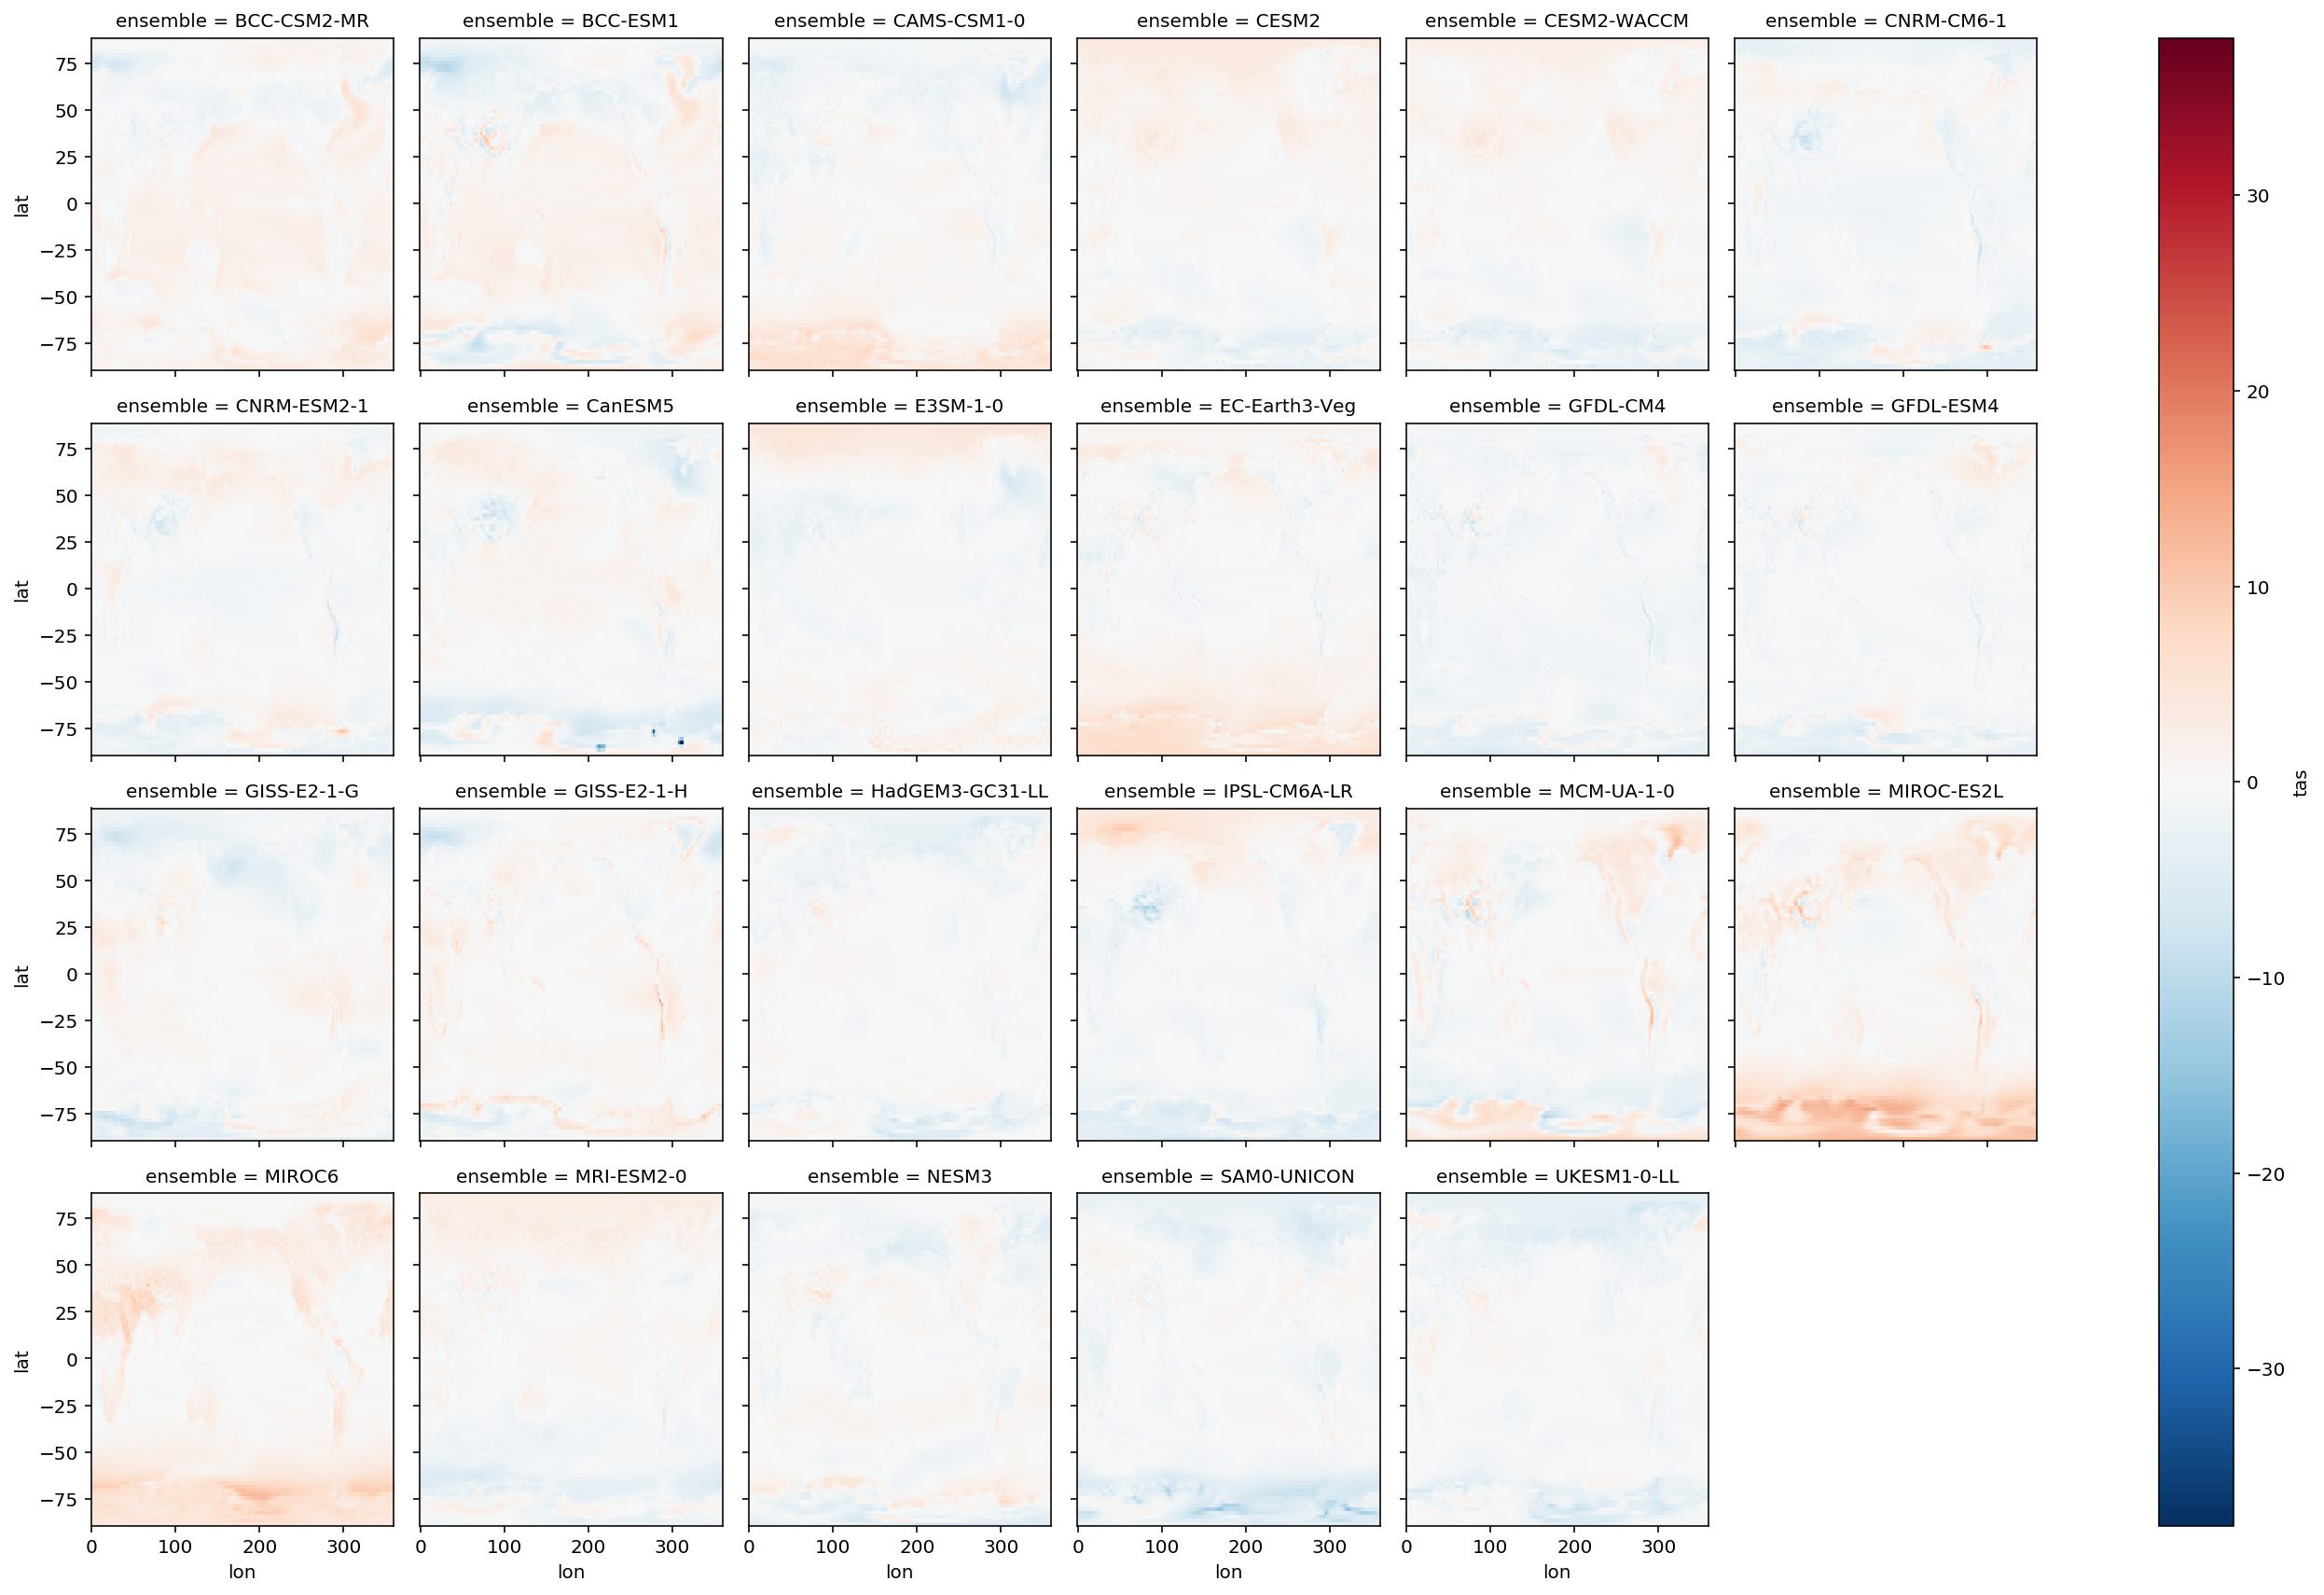

In [52]:
# Plot anomalies with respect to observations (temporarily, actually multi-model mean)
q = (ens-obs).plot(x='lon', y='lat', col='ensemble', col_wrap=6)
# How to change color bar limits?

In [12]:
# Calculate skill of each model run relative to observations
# Note: currently the multi-model mean is a temporary stand-in for observations.
ens.attrs['rmse'] = {}
ens.attrs['mae'] = {}
for ensemble in ens.ensemble:
    ds = ens.sel(ensemble=ensemble)
    ens.attrs['rmse'][str(ensemble.values)] = xs.rmse(obs, ds, ['lat', 'lon']).values
    ens.attrs['mae'][str(ensemble.values)] = xs.mae(obs, ds, ['lat', 'lon']).values
ens.attrs

{'regrid_method': 'bilinear',
 'rmse': {'BCC-CSM2-MR': array(1.65575384),
  'BCC-ESM1': array(2.20923598),
  'CAMS-CSM1-0': array(2.03660009),
  'CESM2': array(1.58787975),
  'CESM2-WACCM': array(1.44785836),
  'CNRM-CM6-1': array(1.67564631),
  'CNRM-ESM2-1': array(1.45252437),
  'CanESM5': array(1.99439207),
  'E3SM-1-0': array(1.59582343),
  'EC-Earth3-Veg': array(2.19161442),
  'GFDL-CM4': array(1.5420321),
  'GFDL-ESM4': array(1.31109796),
  'GISS-E2-1-G': array(1.77539169),
  'GISS-E2-1-H': array(1.58641873),
  'HadGEM3-GC31-LL': array(1.352652),
  'IPSL-CM6A-LR': array(2.16020421),
  'MCM-UA-1-0': array(2.1572245),
  'MIROC-ES2L': array(3.92565732),
  'MIROC6': array(3.04092872),
  'MRI-ESM2-0': array(1.65096503),
  'NESM3': array(1.42512507),
  'SAM0-UNICON': array(2.44762042),
  'UKESM1-0-LL': array(1.80119218)},
 'mae': {'BCC-CSM2-MR': array(1.34470804),
  'BCC-ESM1': array(1.75486936),
  'CAMS-CSM1-0': array(1.43192034),
  'CESM2': array(1.22127247),
  'CESM2-WACCM': array(1

(0, 4.25)

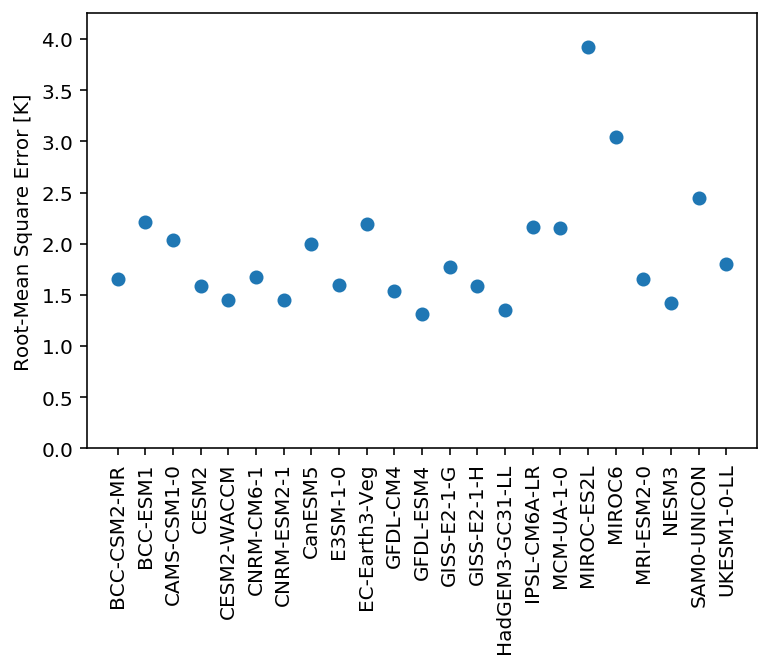

In [13]:
plt.plot(list(ens.attrs['rmse'].values()),'C0o')
plt.xticks(np.arange(len(ens.attrs['rmse'].keys())),list(ens.attrs['rmse'].keys()),rotation=90)
plt.ylabel('Root-Mean Square Error [K]')
plt.ylim([0,4.25])

23